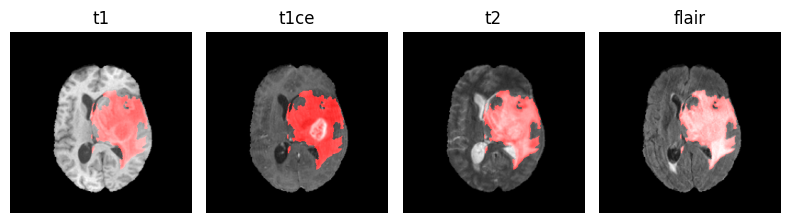

In [5]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
tran_list = [transforms.Resize((256,256)),]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

import matplotlib.pyplot as plt
from scipy import ndimage

b, m, slide_id = next(iter(datal))

from guided_diffusion.utils import visualize, dice_coeff
visualize(b, m)



# from guided_diffusion.unet_parts import BasicUNet
# import torch.nn.functional as F
# seg = BasicUNet(n_channels=4, n_classes=1)
# checkpoint = torch.load('model_nonnormalized.pth')
# seg.load_state_dict(checkpoint['model_state_dict'])
# seg.eval()

# ipex_enabled = False
# bf16 = True

# import time
# start_time = time.time()
# if ipex_enabled:
#     import intel_extension_for_pytorch as ipex
#     if bf16:
#         seg = ipex.optimize(seg, dtype=torch.bfloat16)
#         with torch.no_grad(), torch.cpu.amp.autocast():
#             m_pred = F.sigmoid(seg(b.to(torch.float32)))
#     else:
#         seg = ipex.optimize(seg)
#         m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()
# else:
#     m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()

# print(time.time() - start_time)
# print(dice_coeff(m_pred, m))
# visualize(b, m_pred)

In [15]:
import os
import sys
import random
sys.path.append(".")
import numpy as np
import time
import torch
from guided_diffusion.bratsloader import BRATSDataset
import torchvision.utils as vutils
from guided_diffusion.utils import post_process
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion
)
import torchvision.transforms as transforms


data_dir = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
image_size = 256
batch_size = 1
ipex_enabled = True
bf16 = True
num_ensemble = 1
diffusion_steps = 100
in_ch = 5

tran_list = [transforms.Resize((image_size,image_size))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset(data_dir,transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True)

model, diffusion = create_model_and_diffusion(image_size=image_size, in_ch=in_ch, diffusion_steps=diffusion_steps, version=1)

######################
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(new_state_dict)
######################

model.eval()

if ipex_enabled:
    import intel_extension_for_pytorch as ipex
    print("Intel(R) Extension for PyTorch* enabled")
    if bf16:
        print("BF16 enabled")
        model = ipex.optimize(model, dtype=torch.bfloat16)
    else:
        model = ipex.optimize(model)

b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
c = torch.randn_like(b[:, :1, ...])
img = torch.cat((b, c), dim=1)     #add a noise channel$

enslist = []

for i in range(num_ensemble):  #this is for the generation of an ensemble of 5 masks.
    model_kwargs = {}

    sample_fn = diffusion.p_sample_loop_known
    start_time = time.time()

    if ipex_enabled and bf16:
        with torch.no_grad(), torch.cpu.amp.autocast():
            sample, x_noisy, org, cal, cal_out = sample_fn(
                model,
                (batch_size, in_ch, image_size, image_size), img, ipex_enabled,
                step = diffusion_steps,
                clip_denoised=True,
                model_kwargs=model_kwargs,
            )
    else:
        sample, x_noisy, org, cal, cal_out = sample_fn(
            model,
            (batch_size, in_ch, image_size, image_size), img, 
            ipex_enabled, bf16=False,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )
        
    ensemble_step_time = time.time() - start_time
    post_processed_m = post_process(sample)

    print("--- %s seconds ---" % (ensemble_step_time))


Intel(R) Extension for PyTorch* enabled
--- 36.18535089492798 seconds ---


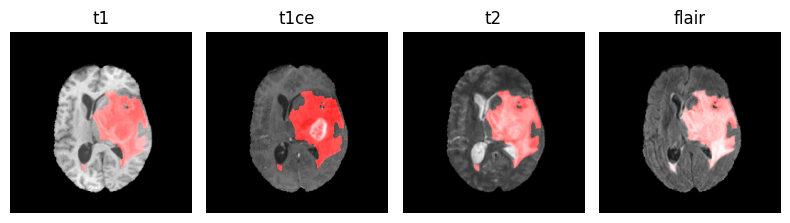

In [12]:
visualize(img, post_processed_m)

In [13]:
dice_coeff(post_processed_m, m)

tensor(0.9315)